---
title: "Some observations on pandas, polars, etc."
author: Ian D. Gow
date: 2026-01-18
date-format: "D MMMM YYYY"
number-sections: true
format:
  html:
    colorlinks: true
  pdf: 
    colorlinks: true
    geometry:
      - left=2cm
      - right=2cm
    papersize: a4
    mainfont: TeX Gyre Pagella
    mathfont: TeX Gyre Pagella Math
bibliography: papers.bib
csl: jfe.csl
jupyter: python3
---


In [1]:
#| include: false
#| eval: false
# !pip3 install pyarrow polars

In [2]:
import pandas as pd
import polars as pl

# Introduction

# Data science in Python and pandas

I will not claim to be any kind of expert on data science in Python.
The following are some observations I've made during a crash course on pandas I'm currently taking.^[This self-taught crash course includes working through *Pandas Cookbook* and *Data Science with Python*.]
 
One approach to the history of data science in Python would go back to the 1990s and describe the emergence of Python, then move on to the development of scientific computing libraries in Python, and so on.
But a shortcut might be to use the excellent book "Data Analysis with Open Source Tools" [@janert2010data], which was published in 2010.

@janert2010data is an excellent book and probably worth reading even today.
However, in some ways its a kind of historical artefact, as so much has changed since 2010.

While the book is fairly eclectic, it focuses on Python---including NumPy and SciPy---and R.
Yet the data frame doesn't appear until Chapter 10 [@janert2010data, p. 244]:

> The essential data structure offered by R is the so-called data frame. 
> A data frame encapsulates a data set and is the central abstraction that R is built on. 
> Practically all operations involve the handling and manipulation of frames in one way or the other.

@janert2010data makes no mention of pandas, which makes sense given the relatively unknown state of pandas in 2010.
While @McKinney_2010 outlines an early iteration of pandas, a [blog post](https://wesmckinney.com/blog/a-roadmap-for-rich-scientific-data-structures-in-python/) by McKinney in 2011 makes it clear that data analysis in Python was still very fragmented and it was still early days for pandas.
But by 2012, pandas was clearly on the map and, while a lot has changed since then, it was possible to write a book entitled "Python for Data Analysis" that focused on pandas. [@mckinney2012python].

  
## pandas as *the* Python data frame library


So what is a data frame library?
The requirements set for pandas by @mckinney2012python [p. 111] provide a starting point:

> - Data structures with labeled axes supporting automatic or explicit data alignment. ...
> - Integrated time series functionality.
> - The same data structures handle both time series data and non-time series data.
> - Arithmetic operations and reductions (like summing across an axis) would pass
on the metadata (axis labels).
> - Flexible handling of missing data.
> - Merge and other relational operations found in popular databases.

The first requirement was implemented in pandas with three closely related data structures: the `Series`, the `Index`, and the `DataFrame`.
As its name suggests, the `DataFrame` is the essential one for a data frame library.
In @mckinney2012python [p. 115] writes that "a DataFrame represents a tabular, spreadsheet-like data structure containing an ordered collection of columns, each of which can be a different value type (numeric, string, boolean, etc.)."
While pandas excels with time series functionality, any data frame library worthy of the name will support temporal data types (dates, timestamps, etc.), along with integer and floating-point numeric types, strings and more.
A typical pandas `DataFrame` will comprise an `Index` and a number of `Series` objects.

Data frame libraries typically include a rich set of functions for reading and writing data in common formats, such as `pd.read_csv()` and `pd.read_parquet()`.

That pandas could be developed so quickly is partly attributable to the early decision to build it on top of the NumPy library, in particular its core `ndarray` data structure.
This decision had a number of consequences for pandas's that can still be felt today.
First, as NumPy had no native notion of missing data, pandas adopted its floating-point "not a number" sentinel (`np.nan`) as a general marker for missing values.

Additionally, NumPy integer arrays cannot represent `np.nan`, so any pandas `Series` containing both integer values and missing data must be coerced to a floating-point type.
Finally, NumPy lacked a suitable native string array type for general text data, forcing pandas to adopt a different internal representation for such data.

In recent years, alternative Python data frame libraries---such as Dask and polars---have emerged.
Today, there are also what might be called **framework libraries**, such as Ibis, that can work with other libraries (such as DuckDB) and systems (such as PostgreSQL) to produce much or all of the functionality of data frame libraries.
Whereas data frame libraries typically define both a data structure and an execution model, framework libraries often define an abstraction layer that can target multiple backends.^[Note, some of these data frame libraries are not limited to Python.
For example, the polars documentation states that polars "is written in Rust, and available for Python, R and NodeJS [sic]." <https://docs.pola.rs>]
These libraries likely emerged in part to address perceived weaknesses in pandas, as I discuss in more detail below.
Nonetheless, it is clear that pandas continues to play a central role in data science in Python.

While R has always provided data frame functionality out of the box, so to speak, it has not stood still since pandas arrived.
For instance, a number of alternative data frame libraries have emerged for R, including `data.table` and the Tidyverse libraries, such as `dplyr` and `tidyr`.^[While `dplyr` supplies much of the core data frame functionality, libraries such as `tidyr` and `readr` are required to fully meet the requirements outlined by @mckinney2012python.]

# Expressive pandas

Since 2012, pandas has become the leading **data frame library** in Python.
A real strength of pandas appears to be its expressiveness, which allows a user to explore data with succinct code.
To show this, I will adapt an example from @hilpisch2019.
The following code reads data from a GitHub page and then one line of code generates a plot.

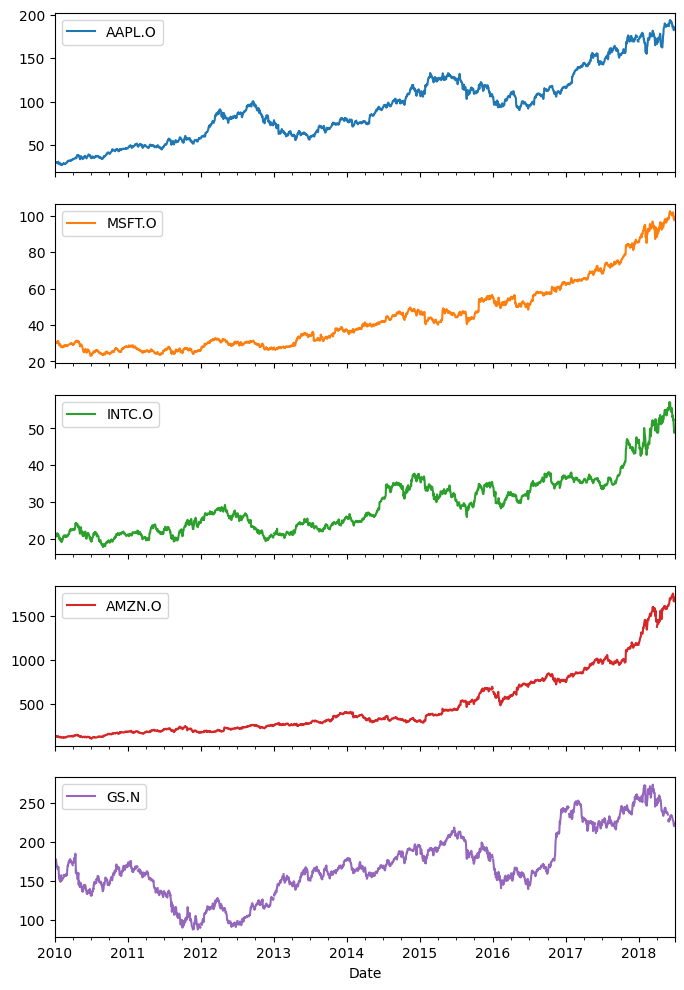

In [3]:
url = ("https://raw.githubusercontent.com/yhilpisch/"
       "py4fi2nd/refs/heads/master/source/"
       "tr_eikon_eod_data.csv")
       
data = (pd
    .read_csv(url, index_col=0, parse_dates=True)
    [["AAPL.O", "MSFT.O", "INTC.O", "AMZN.O", "GS.N"]]
)
data.plot(figsize=(8, 12), subplots=True);

It seems that pandas has intuited that the data set comprises a number of time series, so a call to the `.plot()` method of the `pd.DataFrame` generates a plot and `subplots=True` makes a subplot for each series.
Of course, it wasn't some special instinct for the meaning of data that allowed pandas to do this.
Rather, by having dates in the first column of the CSV and then telling pandas to use that column to generate the `Index` for the `pd.DataFrame`, we get the data in the following form:

In [4]:
data.head()

,AAPL.O,MSFT.O,INTC.O,AMZN.O,GS.N
Date,,,,,
2010-01-01,NaN,NaN,NaN,NaN,NaN
2010-01-04,30.572827,30.950,20.88,133.90,173.08
2010-01-05,30.625684,30.960,20.87,134.69,176.14
2010-01-06,30.138541,30.770,20.80,132.25,174.26
2010-01-07,30.082827,30.452,20.60,130.00,177.67


As can be seen, `Date` is different from the other "columns" of the data frame;
in a sense, it's not a column at all, but the index for the data frame:

In [5]:
data.index

DatetimeIndex(['2010-01-01', '2010-01-04', '2010-01-05', '2010-01-06',
               '2010-01-07', '2010-01-08', '2010-01-11', '2010-01-12',
               '2010-01-13', '2010-01-14',
               ...
               '2018-06-18', '2018-06-19', '2018-06-20', '2018-06-21',
               '2018-06-22', '2018-06-25', '2018-06-26', '2018-06-27',
               '2018-06-28', '2018-06-29'],
              dtype='datetime64[ns]', name='Date', length=2216, freq=None)

In [6]:
data.loc['2010-01-08']

AAPL.O     30.282827
MSFT.O     30.660000
INTC.O     20.830000
AMZN.O    133.520000
GS.N      174.310000
Name: 2010-01-08 00:00:00, dtype: float64

In [7]:
data['AAPL.O']

Date
2010-01-01           NaN
2010-01-04     30.572827
2010-01-05     30.625684
2010-01-06     30.138541
2010-01-07     30.082827
                 ...    
2018-06-25    182.170000
2018-06-26    184.430000
2018-06-27    184.160000
2018-06-28    185.500000
2018-06-29    185.110000
Name: AAPL.O, Length: 2216, dtype: float64

Financial time series data really is pandas's wheelhouse.
This is unsurprising once you realize that pandas began life when Wes McKinney was working at AQR Capital Management.
An important operation for financial time series is **resampling** [@hilpisch2019, p. 215].
For example, we could transform the daily data in `data` into weekly data with one line:

In [8]:
data.resample('W').last().head()

,AAPL.O,MSFT.O,INTC.O,AMZN.O,GS.N
Date,,,,,
2010-01-03,NaN,NaN,NaN,NaN,NaN
2010-01-10,30.282827,30.66,20.83,133.52,174.31
2010-01-17,29.418542,30.86,20.80,127.14,165.21
2010-01-24,28.249972,28.96,19.91,121.43,154.12
2010-01-31,27.437544,28.18,19.40,125.41,148.72


Similarly with monthly data ...

In [9]:
data.resample('ME').last().head()

,AAPL.O,MSFT.O,INTC.O,AMZN.O,GS.N
Date,,,,,
2010-01-31,27.437544,28.1800,19.40,125.41,148.72
2010-02-28,29.231399,28.6700,20.53,118.40,156.35
2010-03-31,33.571395,29.2875,22.29,135.77,170.63
2010-04-30,37.298534,30.5350,22.84,137.10,145.20
2010-05-31,36.697106,25.8000,21.42,125.46,144.26


However, I think there is a danger of overestimating the facility of working with pandas from looking at financial time series data.
My experience is that data sets rarely come in a form that allows one to use a `DatetimeIndex` with series identifiers.
For example, 

In [10]:
from pathlib import Path
import os

def load_parquet(table, schema, *, data_dir=None, type=None):
  if data_dir is None:
    data_dir = Path(os.environ["DATA_DIR"]).expanduser()
  
  path = data_dir / schema / f"{table}.parquet"
  
  if type=="pandas":
    return pd.read_parquet(path)
  else:
    return pl.scan_parquet(path)

In [11]:
#| eval: false
dsf = load_parquet("dsf", "crsp") # , type="pandas")

In [12]:
dsf = load_parquet("dsf", "crsp")
stocknames = load_parquet("stocknames", "crsp")

In [13]:
from datetime import date

start_date = pl.lit(date(2010, 1, 1))
end_date = pl.lit(date(2018, 6, 29))

In [14]:
tickers = (stocknames
    .filter(pl.col("ticker").is_in(["AAPL", "MSFT", "INTC", "AMZN", "GS"]))
    .filter((end_date >= pl.col("namedt")) &
        (end_date <= pl.col("nameenddt")))
    .select("permno", "ticker"))

In [47]:
dsf_sub = (dsf
    .join(tickers.unique(subset=["permno"]), on="permno", how="inner")
    .filter((pl.col("date") >= start_date) & 
            (pl.col("date") <= end_date))
    .select("ticker", "date", "prc", "ret", "retx")
    .with_columns(
        pl.col(["prc", "ret", "retx"]).cast(pl.Float64)
    )
)

In [48]:
last_prc = (
    dsf_sub
    .filter(pl.col("date") <= end_date)
    .sort("date")
    .group_by("ticker")
    .agg(pl.col("prc").last().alias("prc"),
         pl.col("date").last().alias("date"))
    .collect()
)

In [53]:
dsf_adj = (
    dsf_sub
    .sort(["ticker", "date"])
    .with_columns(
        growth=(1.0 + pl.col("retx")).cum_prod().over("ticker")
    )
    .with_columns(
        prc_last=pl.col("prc").last().over("ticker"),
        growth_last=pl.col("growth").last().over("ticker"),
    )
    .with_columns(
        prc=pl.col("prc_last") * pl.col("growth") / 
                pl.col("growth_last")
    )
    .drop(["growth", "prc_last", "growth_last"])
    .collect()
)

In [54]:
data_alt = (dsf_adj
    .pivot(
        index="date",
        on="ticker",
        values="prc")
    .to_pandas()
    .set_index("date"))
    
data_alt = data_alt.reindex(data.index)